<a href="https://colab.research.google.com/github/BarelHeby/Deep-Learning---Chest-X-Ray/blob/main/Deep_Learning_Chest_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---
**FIRST SETUP**

In [1]:
!pip install -q kaggle
from google.colab import files

# Create a Kaggle API token and save it to a file.
!echo '{"username":"barelheby","key":"978bdd6cd1cc991c69bbe920fe75a9cc"}' > kaggle.json

# Copy the Kaggle API token file to the correct location.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# Change the permissions of the Kaggle API token file.
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset.
!unzip chest-xray-pneumonia.zip

# Print the contents of the current working directory.
!ls


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

---
**IMPORTS**

In [2]:
import pandas as pd
from os.path import join
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet152
from keras.layers import BatchNormalization,Dropout,Dense,Flatten
from tensorflow.keras.optimizers import Adamax,Adam
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.manifold import TSNE




---
 **Configuration**


In [3]:
TF_BATCH_SIZE = 32
TF_SEED = 123
IMG_HEIGHT = 256
IMG_WIDTH = 256
DIR_DATASET = "/content/chest_xray"

---
**Normalize Image Function**



---

**Training Set Preprocess**

In [ ]:
train_directory = join(DIR_DATASET,"train")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


---

**Validation Set Prep**

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [ ]:
train_dataset.class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
# train_dataset = train_dataset.map(lambda x,y:(x/255.0,y))
# validation_dataset = validation_dataset.map(lambda x,y:(x/255.0,y))

---
**Part 1 Model**

In [ ]:
base_network = VGG16(weights="imagenet",include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_assigment_1  = Sequential(name="Assigment_1")
model_assigment_1.add(base_network)
model_assigment_1.add(Flatten())
model_assigment_1.add(Dense(512,activation="relu"))
model_assigment_1.add(Dropout(0.50))
model_assigment_1.add(Dense(128,activation="relu"))
model_assigment_1.add(Dropout(0.25))
model_assigment_1.add(Dense(60,activation="relu"))
model_assigment_1.add(Dense(1,activation="sigmoid"))
model_assigment_1.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=['accuracy'])
model_assigment_1.summary()

Model: "Assigment_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model_assigment_1.fit(train_dataset,
                        epochs= 20,
                        validation_data = validation_dataset,
                        callbacks = early_stopping)

Epoch 1/20
131/131 [==============================] - 64s 372ms/step - loss: 0.3917 - accuracy: 0.8548 - val_loss: 0.1423 - val_accuracy: 0.9473
Epoch 2/20
131/131 [==============================] - 38s 279ms/step - loss: 0.1647 - accuracy: 0.9319 - val_loss: 0.1266 - val_accuracy: 0.9521
Epoch 3/20
131/131 [==============================] - 38s 278ms/step - loss: 0.1414 - accuracy: 0.9415 - val_loss: 0.1272 - val_accuracy: 0.9444
Epoch 4/20
131/131 [==============================] - 38s 280ms/step - loss: 0.1204 - accuracy: 0.9554 - val_loss: 0.0937 - val_accuracy: 0.9674
Epoch 5/20
131/131 [==============================] - 39s 284ms/step - loss: 0.1302 - accuracy: 0.9504 - val_loss: 0.1242 - val_accuracy: 0.9473
Epoch 6/20
131/131 [==============================] - 37s 274ms/step - loss: 0.1039 - accuracy: 0.9600 - val_loss: 0.0846 - val_accuracy: 0.9703
Epoch 7/20
131/131 [==============================] - 37s 274ms/step - loss: 0.0905 - accuracy: 0.9660 - val_loss: 0.1010 - val_ac

In [ ]:
validation_loss, validation_accuracy = model_assigment_1.evaluate(validation_dataset)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [ ]:
model_assigment_1.save("model_assigment_1.keras")

In [ ]:
DIR_ASS_2 = join(DIR_DATASET,"assiment_2_dataset")
DIR_ASS_2_BACTERIA  = join(DIR_ASS_2,"BACTERIA")
DIR_ASS_2_VIRUS = join(DIR_ASS_2,"VIRUS")
DIR_ASS_2_NORMAL = join(DIR_ASS_2,"NORMAL")


In [ ]:
try:
  shutil.rmtree(DIR_ASS_2)
except Exception as e:
  print(e)
try:
  os.mkdir(DIR_ASS_2)
  os.mkdir(DIR_ASS_2_BACTERIA)
  os.mkdir(DIR_ASS_2_VIRUS)
  os.mkdir(DIR_ASS_2_NORMAL)
except Exception as e:
  print(e)

[Errno 2] No such file or directory: '/content/chest_xray/assiment_2_dataset'


---
**Copy Images From Source To New Folder**

Copy sick

In [ ]:
# prompt: copy all files from DIR_DATASET/test/PNEUMONIA to DIR_DATASET/assigment_2_dataset
source_dir = join(DIR_DATASET,"train","PNEUMONIA")
for filename in os.listdir(source_dir):
  if "bacteria" in filename.lower():
    dest_dir  = DIR_ASS_2_BACTERIA
  elif "virus" in filename.lower():
    dest_dir = DIR_ASS_2_VIRUS
  else:
    pass
  shutil.copy(join(source_dir,filename),dest_dir)



Copy normal

In [ ]:
source_dir = join(DIR_DATASET,"train","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),DIR_ASS_2_NORMAL)

---
**Assigment 2 preprocess**

In [ ]:
train_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)
validation_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)

Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.


In [ ]:
train_dataset_ass_2.class_names

In [ ]:
# train_dataset_ass_2 = train_dataset_ass_2.map(lambda x,y:(x/255.0,y))
# validation_dataset_ass_2 = validation_dataset_ass_2.map(lambda x,y:(x/255.0,y))

In [ ]:
base_network_ass_2 = ResNet152(include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network_ass_2.trainable = False

234698864/234698864 [==============================] - 2s 0us/step


In [ ]:
model_assigment_2  = Sequential(name="Assigment_2")
model_assigment_2.add(base_network_ass_2)
# model_assigment_2.add(BatchNormalization())
# model_assigment_2.add(Flatten())
# model_assigment_2.add(Dense(512,activation="relu"))
model_assigment_2.add(Dense(1024,activation="relu"))
model_assigment_2.add(Dropout(0.3))
# model_assigment_2.add(BatchNormalization())
model_assigment_2.add(Dense(512,activation="relu"))
# model_assigment_2.add(Dense(256,activation="relu"))
model_assigment_2.add(Dropout(0.2))
# model_assigment_2.add(Dense(128,activation="relu"))
model_assigment_2.add(Dense(64,activation="relu"))
model_assigment_2.add(Dense(3,activation="softmax"))
model_assigment_2.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_assigment_2.summary()

Model: "Assigment_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 3)                 

In [ ]:
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
history_ass_2 = model_assigment_2.fit(train_dataset_ass_2,
                        epochs= 50,
                        validation_data = validation_dataset_ass_2,
                        callbacks = early_stopping)

Epoch 1/50
131/131 [==============================] - 80s 473ms/step - loss: 0.7158 - categorical_accuracy: 0.7033 - val_loss: 0.5433 - val_categorical_accuracy: 0.7785
Epoch 2/50
131/131 [==============================] - 50s 366ms/step - loss: 0.5095 - categorical_accuracy: 0.7764 - val_loss: 0.4759 - val_categorical_accuracy: 0.8006
Epoch 3/50
131/131 [==============================] - 49s 361ms/step - loss: 0.4871 - categorical_accuracy: 0.7872 - val_loss: 0.4811 - val_categorical_accuracy: 0.7939
Epoch 4/50
131/131 [==============================] - 49s 362ms/step - loss: 0.4671 - categorical_accuracy: 0.7994 - val_loss: 0.4883 - val_categorical_accuracy: 0.7862
Epoch 5/50
131/131 [==============================] - 49s 366ms/step - loss: 0.4515 - categorical_accuracy: 0.8133 - val_loss: 0.4550 - val_categorical_accuracy: 0.8102
Epoch 6/50
131/131 [==============================] - 49s 364ms/step - loss: 0.4342 - categorical_accuracy: 0.8172 - val_loss: 0.4886 - val_categorical_acc

In [ ]:
validation_loss, validation_accuracy = model_assigment_2.evaluate(validation_dataset_ass_2)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [ ]:
model_assigment_2.save("model_assigment_2.h5")

**Assigment 2**

---



Train The KNN Classifier Function

In [ ]:
def train_knn_by_model(model,train_data):
  X_train = []
  y_train = []
  for batch, label in train_data:
      X_train.append(model.predict(batch))
      y_train.append(label)
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(X_train, y_train)
  return knn



Function To Classify New Image

In [ ]:
def classify(new_image_path,model,knn_model,class_names,assigment_number):
  new_image = Image.open(new_image_path)
  new_image = new_image.resize((IMG_WIDTH,IMG_HEIGHT))
  new_image_array = np.array(new_image)
  new_image_array = np.expand_dims(new_image_array,axis=0)
  new_image_array = np.expand_dims(new_image_array,axis=-1)
  new_image_array = np.repeat(new_image_array, 3, axis=-1)
  new_image_tensor = tf.convert_to_tensor(new_image_array,tf.float32)
  # Create the embedding vector for the image
  new_image_embedding = model.predict(new_image_tensor)
  print("New Image Embedding",new_image_embedding)
  # Use knn to predict
  y_pred_knn = knn_model.predict(new_image_embedding)
  if assigment_number==1:
    return class_names[y_pred_knn[0]]
  y_pred_knn = y_pred_knn[0]
  for i in range(len(y_pred_knn)):
    if int(y_pred_knn[i])==1:
      return class_names[i]

Predict New Image - Assigment 1.a

---



In [ ]:
knn_model_ass_1 = train_knn_by_model(model_assigment_1,train_dataset)

In [ ]:
ass_1_class_names = ["NORMAL","PNEUMONIA"]
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_1,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_2,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_3 = "/content/chest_xray/test/NORMAL/IM-0043-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))

1/1 [==============================] - 0s 22ms/step
New Image Embedding [[1.]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 18ms/step
New Image Embedding [[0.9999639]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 19ms/step
New Image Embedding [[0.02433015]]
Expected: NORMAL, Got: NORMAL


Predict New Image Using KNN  

In [ ]:
knn_model_ass_2 = train_knn_by_model(model_assigment_2,train_dataset_ass_2)

1/1 [==============================] - 3s 3s/step


In [ ]:
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: BACTERIA, Got:", classify(img_1,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: VIRUS, Got:", classify(img_2,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_3 = "/content/chest_xray/test/NORMAL/IM-0011-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))

1/1 [==============================] - 1s 858ms/step
New Image Embedding [[9.2696357e-01 2.3935957e-06 7.3033988e-02]]
Expected: BACTERIA, Got: BACTERIA
1/1 [==============================] - 0s 37ms/step
New Image Embedding [[0.5186558  0.00390507 0.4774391 ]]
Expected: VIRUS, Got: VIRUS
1/1 [==============================] - 0s 38ms/step
New Image Embedding [[0.1604642  0.7407988  0.09873704]]
Expected: NORMAL, Got: NORMAL


Create Scatter Plots

In [ ]:
embeddings_1 = model_assigment_1.predict(train_dataset)


131/131 [==============================] - 34s 246ms/step


In [ ]:

tsne_data_1 = TSNE(n_components=1,perplexity=15)
tsne_data_1 = tsne_data_1.fit_transform(embeddings_1)
df_1 = pd.DataFrame(tsne_data_1, columns=["x"])
X_1 = df_1["x"]

y_names_1 = [validation_dataset.class_names[0 if row <0.5 else 1] for row in tsne_data_1]
fig_1 = px.scatter(df_1, color=y_names_1, opacity=0.8)
fig_1.show()


In [ ]:
embeddings_2 = model_assigment_2.predict(train_dataset_ass_2)

131/131 [==============================] - 40s 296ms/step


In [ ]:

tsne_data_2 = TSNE(n_components=3,perplexity=15).fit_transform(embeddings_2)
df = pd.DataFrame(tsne_data_2, columns=["x", "y", "z"])
X = df["x"]
y = df["y"]
z = df["z"]

y_names = [validation_dataset_ass_2.class_names[np.argmax(row)] for row in tsne_data_2]
fig = px.scatter(x=X, y=y,  color=y_names, opacity=0.8)
fig.show()


**Assigment 3**

In [4]:
# prompt: Copy from train_directory_ass_3 to new folder all pictures under NORMAL folder

source_dir = join(DIR_DATASET,"train","NORMAL")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3","NORMAL"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3 = join(DIR_DATASET,"train_directory_ass_3")

In [5]:
validation_directory_ass_3 = join(DIR_DATASET,"train")
train_dataset_ass_3 = tf.keras.utils.image_dataset_from_directory(
    train_directory_ass_3,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
)
validation_dataset_ass_3 = tf.keras.utils.image_dataset_from_directory(
    train_directory_ass_3,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

Found 1341 files belonging to 1 classes.
Using 1073 files for training.
Found 1341 files belonging to 1 classes.
Using 268 files for validation.


In [6]:
# prompt: use train_dataset_ass_3 and validation_dataset_ass_3 to create network that classify new images using anomaly detection

import pandas as pd
from keras.layers import Conv2D,UpSampling2D,Reshape
# BASE NETWORK
base_network_ass_3 = VGG16(include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="max")
base_network_ass_3.trainable = False
autoencoder   = Sequential(name="autoencoder_assigment_3")
autoencoder.add(base_network_ass_3)
autoencoder.add(Flatten())
autoencoder.add(Dense(32,activation="relu"))
autoencoder.add(Dense(8*8*512,activation="relu"))
autoencoder.add(Reshape((8,8,512)))
autoencoder.add(Conv2D(256,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(128,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(64,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(3,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(3,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(3,(3,3),activation="sigmoid",padding="same"))
# autoencoder.add(Dense(60,activation="relu"))
# DECODER
# autoencoder.add(Dense(128,activation="relu"))
# autoencoder.add(Dense(512,activation="relu"))
# autoencoder.add(Dense(IMG_HEIGHT*IMG_WIDTH,activation="sigmoid"))
autoencoder.compile(optimizer="adam",loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()



58889256/58889256 [==============================] - 4s 0us/step
Model: "autoencoder_assigment_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 32768)             1081344   
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1179904   
                                            

In [7]:
# prompt: use train_dataset_ass_3 and validation_dataset_ass_3 to create network that classify new images using anomaly detection

import pandas as pd
from keras.layers import Conv2D,UpSampling2D,Reshape,Input,MaxPooling2D
# BASE NETWORK
base_network_ass_3 = VGG16(include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="max")
base_network_ass_3.trainable = False
autoencoder   = Sequential(name="autoencoder_assigment_3")
# autoencoder.add(base_network_ass_3)
autoencoder.add(Input((256,256,3)))
autoencoder.add(Conv2D(16,(3,3),activation="relu",padding="same"))
# autoencoder.add(MaxPooling2D())
# autoencoder.add(Conv2D(4,(3,3),activation="relu",padding="same"))
autoencoder.add(MaxPooling2D())
autoencoder.add(Conv2D(4,(3,3),activation="relu",padding="same"))
autoencoder.add(MaxPooling2D())
autoencoder.add(Flatten())
autoencoder.add(Dense(32*32*2,activation="relu"))
autoencoder.add(Dense(32*2,activation="relu"))
autoencoder.add(Dense(32*32*2,activation="relu"))
# autoencoder.add(Dense(8*8*512,activation="relu"))
autoencoder.add(Reshape((32,32,2)))
autoencoder.add(Conv2D(4,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(4,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(4,(3,3),activation="relu",padding="same"))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(3,(3,3),activation="sigmoid",padding="same"))
autoencoder.compile(optimizer="adam",loss='mse', metrics=['accuracy'])
autoencoder.summary()



Model: "autoencoder_assigment_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 4)       580       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 4)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 2048)  

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_data_ass_3 = datagen.flow_from_directory(train_directory_ass_3,
                                               target_size=(256,256),
                                               batch_size=32,
                                               class_mode="input",
                                               subset="training"
                                               )
val_data_ass_3 = datagen.flow_from_directory(train_directory_ass_3,
                                               target_size=(256,256),
                                               batch_size=32,
                                               class_mode="input",
                                               subset="validation"
                                               )

Found 1073 images belonging to 1 classes.
Found 268 images belonging to 1 classes.


In [9]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history_ass_3 = autoencoder.fit(train_data_ass_3,
                        epochs= 20,
                        validation_data = val_data_ass_3,
                        callbacks = [early_stopping])

Epoch 1/20
34/34 [==============================] - 44s 833ms/step - loss: 0.0544 - accuracy: 0.1057 - val_loss: 0.0494 - val_accuracy: 0.1284
Epoch 2/20
34/34 [==============================] - 26s 761ms/step - loss: 0.0441 - accuracy: 0.2952 - val_loss: 0.0410 - val_accuracy: 0.3146
Epoch 3/20
34/34 [==============================] - 32s 958ms/step - loss: 0.0364 - accuracy: 0.1898 - val_loss: 0.0334 - val_accuracy: 0.1645
Epoch 4/20
34/34 [==============================] - 26s 759ms/step - loss: 0.0293 - accuracy: 0.1969 - val_loss: 0.0263 - val_accuracy: 0.1974
Epoch 5/20
34/34 [==============================] - 25s 739ms/step - loss: 0.0231 - accuracy: 0.2173 - val_loss: 0.0206 - val_accuracy: 0.2181
Epoch 6/20
34/34 [==============================] - 26s 764ms/step - loss: 0.0185 - accuracy: 0.2254 - val_loss: 0.0170 - val_accuracy: 0.2277
Epoch 7/20
34/34 [==============================] - 48s 1s/step - loss: 0.0155 - accuracy: 0.2176 - val_loss: 0.0143 - val_accuracy: 0.2103


In [10]:
prediction = autoencoder.predict(val_data_ass_3)


9/9 [==============================] - 6s 645ms/step


In [11]:
import matplotlib.pyplot as plt

def display_image(image):
  plt.imshow(image,cmap="gray")
  plt.axis("off")
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import itertools
from PIL import Image
# p = prediction.astype(np.uint8)
i=0
for i in range(5):
    # if i>10:
      # break
    # index_lookup = val_data_ass_3.index_lookup
    pred = prediction[i]
    val = val_data_ass_3.filepaths[i]
    # item_lable = val_data_ass_3.class_names
    val = Image.open(val)
    val = np.array(val)
    # val.save("mymy.png")
    print("Origin")
    plt.imshow(val,cmap="gray")
    plt.gray()
    # plt.show()
    print("Prediction")
    plt.imshow(pred)
plt.show()
    # img.show("title")
    # display_image(image[0])
    # Select a single image from the batch
    # single_image = image.reshape((28, 28, 3))
    # Reshape the image into a 28x28 shape
    # single_image = single_image.reshape(28, 28)
    # Display the image
    # plt.imshow(single_image,cmap="gray")
    # plt.title(np.argmax(label[0]))
    # plt.axis("off")
    # plt.show()
    # break


In [112]:
test_directory = join(DIR_DATASET,"test")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    # validation_split=0.2,
    # subset = "training",
    # seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode="binary",

)

Found 624 files belonging to 2 classes.


In [115]:
test_dataset.as_numpy_iterator()

TypeError: '_PrefetchDataset' object is not subscriptable

In [113]:
prediction_test = autoencoder.predict(test_dataset)

20/20 [==============================] - 3s 111ms/step


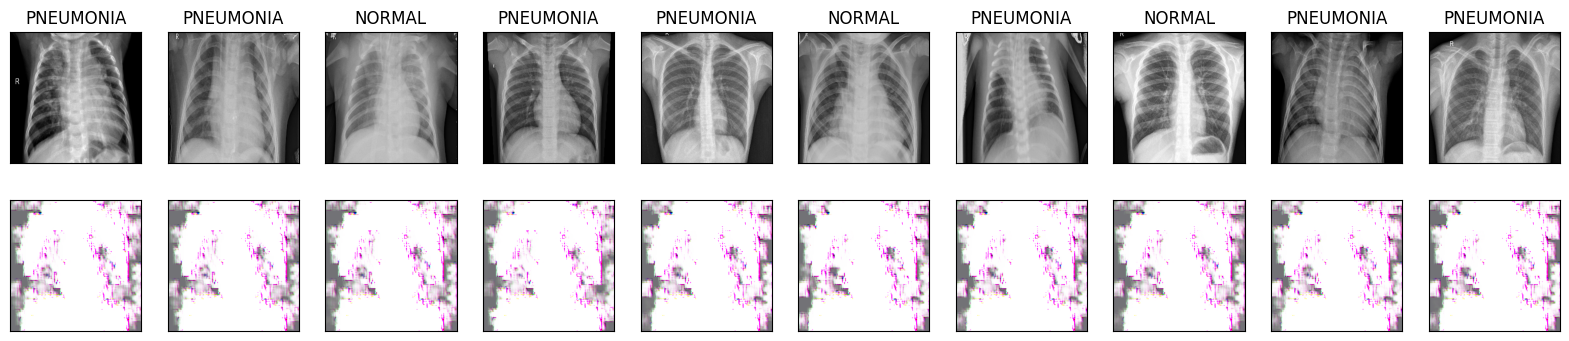

In [127]:
# prompt: show the first 10 images in the prediction and the val_data_ass_3 in 2 rows

import matplotlib.pyplot as plt
n = 10

plt.figure(figsize=(20, 4))
iterator = iter(test_dataset)
for i in range(n):

    val, first_label = next(iterator)
    # print(test_dataset.class_names[int(first_label.numpy()[1][0])])
    # break
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val[i].numpy().astype("uint8"), cmap='gray')
    plt.title(test_dataset.class_names[int(first_label.numpy()[1][0])])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(prediction_test[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()



In [ ]:
validation_loss, validation_accuracy = model_assigment_3.evaluate(validation_dataset_ass_3)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)
# model_assigment_3.save("model_assigment_3.keras")
# Create Scatter Plots
embeddings_3 = model_assigment_3.predict(train_dataset_ass_3)


tsne_data_3 = TSNE(n_components=1,perplexity=15)
tsne_data_3 = tsne_data_3.fit_transform(embeddings_3)
df_3 = pd.DataFrame(tsne_data_3, columns=["x"])
X_3 = df_3["x"]

y_names_3 = [validation_dataset_ass_3.class_names[0] if row <0.5  else "SICK" for row in tsne_data_3]
fig_3 = px.scatter(df_3, color=y_names_3, opacity=0.8)
fig_3.show()

9/9 [==============================] - 5s 159ms/step - loss: 6.5849e-20 - accuracy: 1.0000
Validation Loss: 6.584888234736871e-20
Validation Accuracy: 1.0
34/34 [==============================] - 17s 402ms/step
